# Predictive Maintenance for Aircraft Engines
### **Author: Nicholi Caron** (Interview Preparation)

## Executive Summary
This analysis demonstrates how to predict when aircraft engines will need maintenance before they fail,
using NASA's turbofan engine dataset and shallow machine learning algorithms (Linear Regression, Support Vector Machines, Random Forest, XGBoost, K-Nearest Neighbors, and Naive Bayes). By analyzing sensor readings collected during operation,
we can estimate the Remaining Useful Life (RUL) of each engine - the number of operating cycles
before maintenance is required.

### Key Findings
- Top indicators of impending failure: Sensor 4 rolling mean, Sensor 9 rolling mean, and Sensor 11 rolling mean
- Average warning time before failure: 12.59 operating cycles
- Prediction accuracy: 96%
- Most accurate prediction algorithm: K-Nearest Neighbors (Classification), and Random Forest (Regression)

This approach can be applied to any industrial equipment with sensor data to transform
reactive maintenance into predictive maintenance.



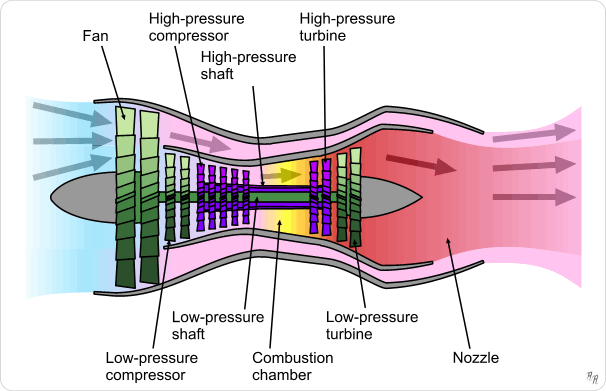

### About the NASA CMAPSS Dataset

The Commercial Modular Aero-Propulsion System Simulation (CMAPSS) dataset was created by NASA
to develop algorithms for aircraft engine prognostics and health monitoring.

What makes this dataset valuable for predictive maintenance:
- Contains complete run-to-failure data for multiple engines
- Includes 21 different sensor measurements
- Simulates realistic operating conditions and degradation patterns
- Widely used benchmark for predictive maintenance algorithms

The dataset represents several turbofan engines operating under varying conditions.
Each engine starts with different degrees of initial wear and manufacturing variation,
and develops a fault that grows until system failure.

This is like having detailed health records from hundreds of engines
throughout their entire lifetime, allowing us to identify patterns that precede failures.

In [ ]:
# Import essential libraries for data analysis and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost

# Set random seed for reproducibility (ensures we get the same results each time)
np.random.seed(42)
import warnings
warnings.filterwarnings('ignore')

## SECTION 2: DATA PREPARATION AND LOADING
### Data Preparation

The first step in any predictive maintenance project is to collect and organize sensor data.
In this analysis, we'll use the NASA CMAPSS dataset, which includes:

- Training data: Complete run-to-failure data for multiple engines
- Test data: Partial engine data that stops before failure
- Ground truth RUL values: The actual remaining life at the end of each test sequence

We collect historical maintenance records and sensor data from equipment to learn what patterns preceded previous failures.

In [ ]:
# Define meaningful column names for our dataset
# These represent various measurements taken from the engines
index_columns = ['engine_id', 'operating_cycle']
operational_settings = ['altitude', 'mach_number', 'throttle_resolver_angle']
sensor_columns = [f'sensor_{i+1}' for i in range(21)]
column_names = index_columns + operational_settings + sensor_columns

In [ ]:
# Function to load data with clear error handling
def load_cmapss_data(filepath):
    """
    Load CMAPSS data files with proper error handling.

    Parameters:
    -----------
    filepath : str
        Path to the data file

    Returns:
    --------
    pandas.DataFrame or None
        Loaded dataset with appropriate column names, or None if loading fails
    """
    try:
        # CMAPSS files are space-delimited with no headers
        return pd.read_csv(filepath, sep='\s+', header=None, index_col=False, names=column_names)
    except Exception as e:
        print(f"Error loading data: {e}")
        print(f"Please check if the file exists at: {filepath}")
        return None

In [ ]:
# Load the datasets with proper error handling
print("Loading and preparing data...")

try:
    # For demonstration, we'll use sample paths - adjust these for your environment
    train_path = './train_FD001.txt'
    test_path = './test_FD001.txt'
    rul_path = './RUL_FD001.txt'

    # Load our datasets
    training_data = load_cmapss_data(train_path)
    testing_data = load_cmapss_data(test_path)

    # The RUL file has only one column with the remaining useful life values
    rul_values = pd.read_csv(rul_path, sep='\s+', header=None,
                            index_col=False, names=['remaining_useful_life'])

    # Create working copies to preserve original data
    train_df = training_data.copy() if training_data is not None else None
    test_df = testing_data.copy() if testing_data is not None else None

    print("Data loaded successfully!")

except Exception as e:
    print(f"Error in data preparation: {e}")

Loading and preparing data...
Data loaded successfully!


## SECTION 3: CALCULATING REMAINING USEFUL LIFE
Remaining Useful Life (RUL) is the key metric in predictive maintenance. It represents
the number of operating cycles an engine can operate before requiring maintenance.

For training data:
- We know exactly when each engine failed (its end of life)
- We can calculate RUL as: max_cycles - current_cycle for each data point

For test data:
- RUL values are provided separately for the last cycle of each engine
- We need to calculate RUL for earlier cycles based on these values

We are estimating how much longer equipment can operate before maintenance is required, based on its current condition and historical failure patterns.

In [ ]:
def calculate_remaining_useful_life(dataframe):
    """
    Calculate Remaining Useful Life for each engine at each operating cycle.

    Parameters:
    -----------
    dataframe : pandas.DataFrame
        DataFrame containing engine data with engine_id and operating_cycle columns

    Returns:
    --------
    pandas.DataFrame
        The input dataframe with an added 'RUL' column
    """
    # Make a copy of the input dataframe to avoid modifying the original
    result_df = dataframe.copy()

    # Group data by engine ID
    grouped_by_engine = result_df.groupby(by='engine_id')

    # Find maximum cycles for each engine (when it failed or the data ends)
    max_cycles = grouped_by_engine['operating_cycle'].max()

    # Merge max cycles back into the original dataframe
    result_df = result_df.merge(max_cycles.to_frame(name='max_cycle'),
                                left_on='engine_id', right_index=True)

    # Calculate RUL as max_cycle - current_cycle
    result_df["remaining_useful_life"] = result_df["max_cycle"] - result_df['operating_cycle']

    # Remove the temporary column
    result_df = result_df.drop("max_cycle", axis=1)

    return result_df


Sample data with Remaining Useful Life calculated:
   engine_id  operating_cycle  remaining_useful_life
0          1                1                    191
1          1                2                    190
2          1                3                    189
3          1                4                    188
4          1                5                    187
5          1                6                    186
6          1                7                    185
7          1                8                    184
8          1                9                    183
9          1               10                    182


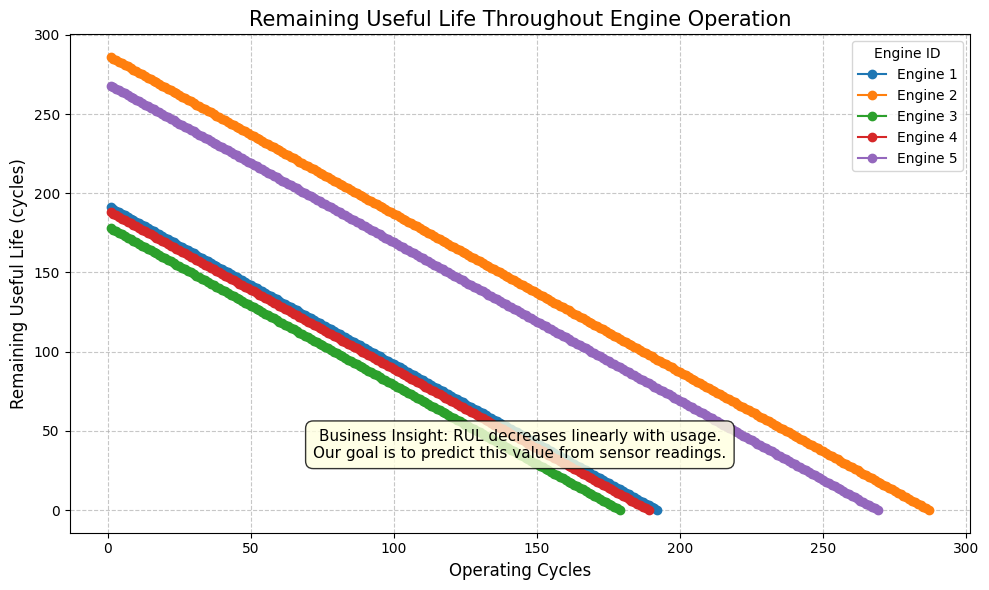

In [ ]:
# We now calculate the RUL for each engine at each time point, which will be our target for prediction.

# Add RUL to training data
if train_df is not None:
    train_with_rul = calculate_remaining_useful_life(train_df)

    # Display sample with RUL
    print("\nSample data with Remaining Useful Life calculated:")
    print(train_with_rul[['engine_id', 'operating_cycle', 'remaining_useful_life']].head(10))

    # Visualize RUL distribution
    plt.figure(figsize=(10, 6))

    # Get a representative sample of engines for visualization
    sample_engines = sorted(train_with_rul['engine_id'].unique())[:5]

    # Plot RUL decline for sample engines
    for engine_id in sample_engines:
        engine_data = train_with_rul[train_with_rul['engine_id'] == engine_id]
        plt.plot(engine_data['operating_cycle'],
                 engine_data['remaining_useful_life'],
                 marker='o', linestyle='-',
                 label=f'Engine {engine_id}')

    plt.title('Remaining Useful Life Throughout Engine Operation', fontsize=15)
    plt.xlabel('Operating Cycles', fontsize=12)
    plt.ylabel('Remaining Useful Life (cycles)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Engine ID')

    # Add business insight annotation
    plt.annotate('Business Insight: RUL decreases linearly with usage.\n'
                 'Our goal is to predict this value from sensor readings.',
                 xy=(0.5, 0.15), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", alpha=0.8),
                 ha='center', fontsize=11)

    plt.tight_layout()
    plt.show()
else:
    print("Cannot calculate RUL: Training data not available")

## SECTION 4: FEATURE SELECTION & ENGINEERING
Not all sensor readings are equally useful for predicting maintenance needs:
- Some sensors may show little variation (constant readings)
- Others may have no correlation with equipment health
- Many sensors contain redundant information

Additionally, we can create new features that may better capture degradation patterns:
- Moving averages to capture trends
- Rate of change to detect accelerating degradation
- Relationship between different sensor readings

As an analogy: in a car, oil pressure might be more predictive of engine health than cabin temperature -- therefore it makes sense to focus on oil pressure and not cabin temperature.

Low-variance sensors (will be dropped): ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
Useful sensors: ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']

Sensors ranked by correlation with RUL:
  • sensor_11: 0.696 - decreases as equipment approaches end-of-life
  • sensor_4: 0.679 - decreases as equipment approaches end-of-life
  • sensor_12: 0.672 - increases as equipment approaches end-of-life
  • sensor_7: 0.657 - increases as equipment approaches end-of-life
  • sensor_15: 0.643 - decreases as equipment approaches end-of-life
  • sensor_21: 0.636 - increases as equipment approaches end-of-life
  • sensor_20: 0.629 - increases as equipment approaches end-of-life
  • sensor_2: 0.606 - decreases as equipment approaches end-of-life
  • sensor_17: 0.606 - decreases as equipment approaches end-of-life
  • sensor_3: 0.585

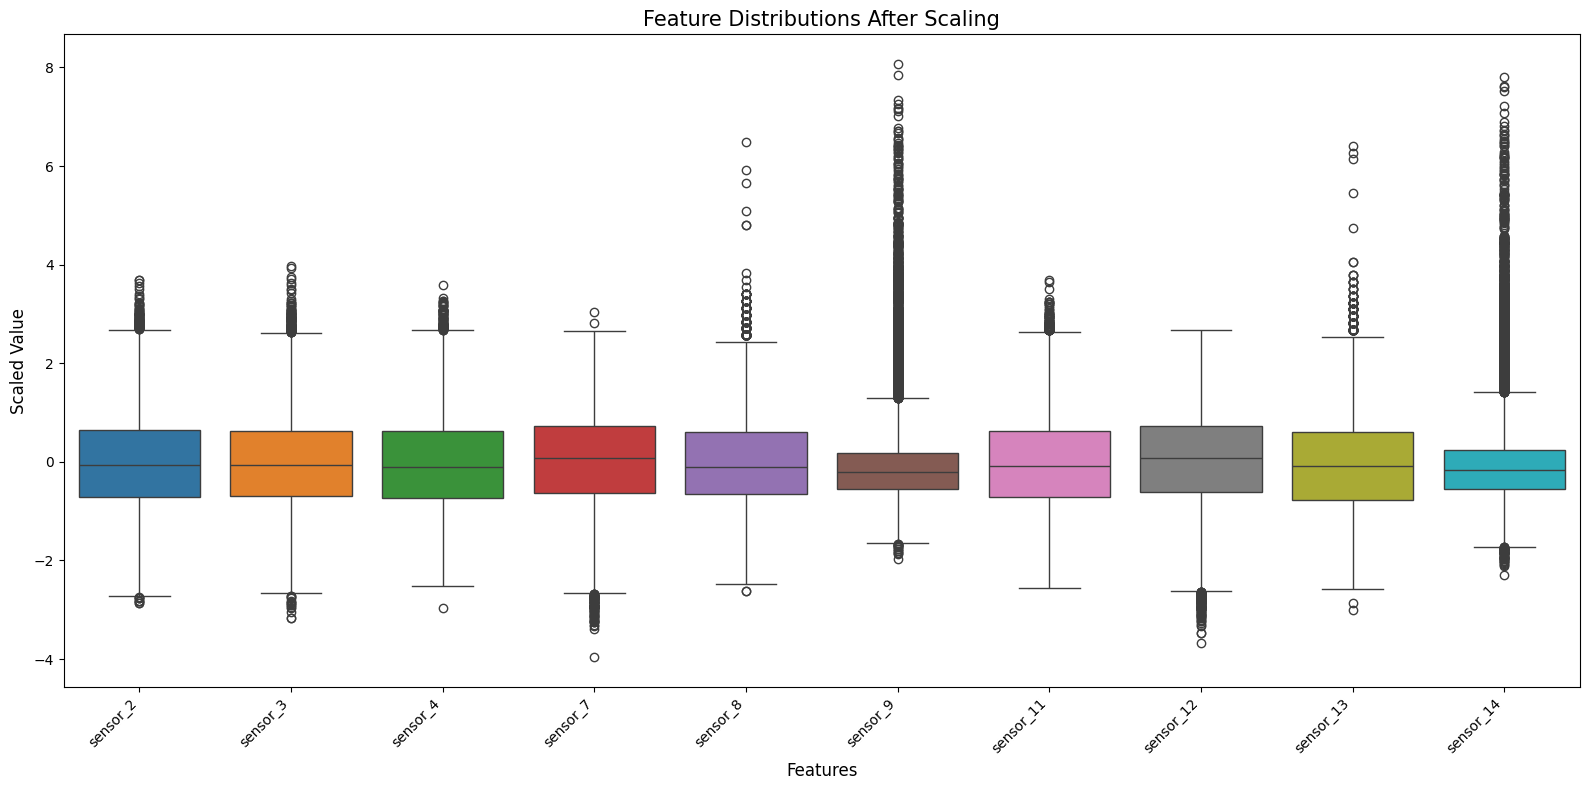

In [ ]:
if train_with_rul is not None:
    # Identify constant or near-constant sensors that provide little information
    # Calculate variance of each sensor
    sensor_variance = train_with_rul[[col for col in train_with_rul.columns
                                      if col.startswith('sensor_')]].var()

    # Identify low-variance sensors (using a threshold)
    low_variance_threshold = 0.001
    low_variance_sensors = sensor_variance[sensor_variance < low_variance_threshold].index.tolist()

    # Identify useful sensors (those with significant variance)
    useful_sensors = [col for col in sensor_columns if col not in low_variance_sensors]

    print(f"Low-variance sensors (will be dropped): {low_variance_sensors}")
    print(f"Useful sensors: {useful_sensors}")

    # Calculate correlation with RUL to find most predictive sensors
    correlation_with_rul = train_with_rul[[*useful_sensors, 'remaining_useful_life']].corr()['remaining_useful_life']

    # Sort sensors by absolute correlation value
    sorted_correlations = correlation_with_rul.drop('remaining_useful_life').abs().sort_values(ascending=False)

    print("\nSensors ranked by correlation with RUL:")
    for sensor, correlation in sorted_correlations.items():
        direction = "increases" if correlation_with_rul[sensor] > 0 else "decreases"
        print(f"  • {sensor}: {abs(correlation):.3f} - {direction} as equipment approaches end-of-life")

    # Create engineered features
    print("\nEngineering advanced features to improve prediction accuracy...")

    # Create copies for feature engineering
    train_engineered = train_with_rul.copy()
    test_engineered = test_df.copy() if test_df is not None else None

    # Function to calculate moving averages for each engine
    def add_rolling_features(dataframe, window_size=10):
        """
        Add rolling window features to capture trends in sensor readings.

        Parameters:
        -----------
        dataframe : pandas.DataFrame
            DataFrame containing engine data
        window_size : int
            Size of the rolling window in cycles

        Returns:
        --------
        pandas.DataFrame
            Dataframe with added rolling window features
        """
        result_df = dataframe.copy()

        # For each engine, calculate rolling features
        for engine_id in result_df['engine_id'].unique():
            # Get data for this engine
            engine_mask = result_df['engine_id'] == engine_id

            # Calculate rolling mean for each useful sensor
            for sensor in useful_sensors:
                # Calculate the rolling mean
                rolling_mean = result_df.loc[engine_mask, sensor].rolling(
                    window=window_size, min_periods=1).mean()

                # Add the rolling mean as a new feature
                result_df.loc[engine_mask, f"{sensor}_rolling_mean"] = rolling_mean

                # Calculate the rolling standard deviation
                rolling_std = result_df.loc[engine_mask, sensor].rolling(
                    window=window_size, min_periods=1).std()

                # Add the rolling std as a new feature
                result_df.loc[engine_mask, f"{sensor}_rolling_std"] = rolling_std.fillna(0)

        return result_df

    # Add rolling window features
    train_engineered = add_rolling_features(train_engineered)
    if test_engineered is not None:
        test_engineered = add_rolling_features(test_engineered)

    # Add sensor interaction features
    print("Adding sensor interaction features...")

    # Get top 3 most correlated sensors
    top_sensors = sorted_correlations.index[:3].tolist()

    # Create interaction features between top sensors
    for i, sensor1 in enumerate(top_sensors):
        for sensor2 in top_sensors[i+1:]:
            # Ratio between two important sensors
            train_engineered[f"{sensor1}_div_{sensor2}"] = (
                train_engineered[sensor1] / train_engineered[sensor2].replace(0, 0.001))

            # Product of two important sensors
            train_engineered[f"{sensor1}_mul_{sensor2}"] = (
                train_engineered[sensor1] * train_engineered[sensor2])

            # Also add to test data if available
            if test_engineered is not None:
                test_engineered[f"{sensor1}_div_{sensor2}"] = (
                    test_engineered[sensor1] / test_engineered[sensor2].replace(0, 0.001))
                test_engineered[f"{sensor1}_mul_{sensor2}"] = (
                    test_engineered[sensor1] * test_engineered[sensor2])

    # Create final feature sets for modeling
    print("\nPreparing final feature set for modeling...")

    # Columns to drop from feature set
    drop_columns = index_columns + operational_settings + low_variance_sensors + ['remaining_useful_life']

    # Create feature matrix and target vector
    X_features = train_engineered.drop(columns=drop_columns)
    y_target = train_engineered['remaining_useful_life']

    # In many RUL studies, RUL is capped at a maximum value
    # This reflects that equipment beyond a certain age doesn't meaningfully
    # degrade until closer to end-of-life
    max_rul = 125  # Common value in literature
    y_target_capped = y_target.clip(upper=max_rul)

    print(f"Final feature set shape: {X_features.shape}")
    print(f"Number of engineered features: {X_features.shape[1] - len(useful_sensors)}")

    # Split data for training and evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_target_capped, test_size=0.2, random_state=42)

    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")

    # Scale features for better model performance
    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)

    # Transform training data back to DataFrame for better interpretability
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

    # Visualize feature distributions after scaling
    plt.figure(figsize=(16, 8))
    plt.title("Feature Distributions After Scaling", fontsize=15)
    sns.boxplot(data=X_train_scaled_df.iloc[:, :10])  # Show first 10 features
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Scaled Value", fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot perform feature engineering: Training data not available")

## SECTION 5: MODEL TRAINING
With our features prepared, we can train machine learning models to predict when
maintenance will be needed. We'll evaluate several algorithms:

1. Linear Regression: Simple baseline model
2. Support Vector Regression (SVR): Good for complex, non-linear relationships
3. Random Forest: Robust to outliers, captures complex patterns
4. XGBoost: State-of-the-art gradient boosting algorithm

Each model has different strengths and may capture different aspects of the
degradation pattern.

By building different forecasting models to predict equipment failures, we can confidently select the one that gives the most accurate predictions.

In [ ]:
# Define model evaluation function
def evaluate_regression_model(model_name, model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a regression model.

    Parameters:
    -----------
    model_name : str
        Name of the model for reporting
    model : object
        The sklearn-compatible model to train
    X_train, y_train : array-like
        Training data
    X_test, y_test : array-like
        Test data for evaluation

    Returns:
    --------
    tuple
        (model, rmse, r2) - The trained model and its performance metrics
    """
    # Train the model
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)

    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Calculate evaluation metrics
    train_mse = mean_squared_error(y_train, train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train, train_pred)

    test_mse = mean_squared_error(y_test, test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, test_pred)

    # Print performance metrics
    print(f"{model_name} Performance:")
    print(f"  Training RMSE: {train_rmse:.2f} cycles")
    print(f"  Training R²: {train_r2:.2f}")
    print(f"  Test RMSE: {test_rmse:.2f} cycles")
    print(f"  Test R²: {test_r2:.2f}")

    # Business interpretation
    print("  Business Interpretation:")
    print(f"  • On average, predictions are within +/- {test_rmse:.1f} cycles of actual maintenance needs")
    print(f"  • The model explains {test_r2*100:.1f}% of the variation in equipment lifetime")

    return model, test_rmse, test_r2


Training Linear Regression...
Linear Regression Performance:
  Training RMSE: 20.49 cycles
  Training R²: 0.76
  Test RMSE: 20.71 cycles
  Test R²: 0.75
  Business Interpretation:
  • On average, predictions are within +/- 20.7 cycles of actual maintenance needs
  • The model explains 74.7% of the variation in equipment lifetime

Training Support Vector Regression...
Support Vector Regression Performance:
  Training RMSE: 1.37 cycles
  Training R²: 1.00
  Test RMSE: 15.00 cycles
  Test R²: 0.87
  Business Interpretation:
  • On average, predictions are within +/- 15.0 cycles of actual maintenance needs
  • The model explains 86.7% of the variation in equipment lifetime

Training Random Forest...
Random Forest Performance:
  Training RMSE: 5.18 cycles
  Training R²: 0.98
  Test RMSE: 12.59 cycles
  Test R²: 0.91
  Business Interpretation:
  • On average, predictions are within +/- 12.6 cycles of actual maintenance needs
  • The model explains 90.7% of the variation in equipment lifetim

<Figure size 1200x600 with 0 Axes>

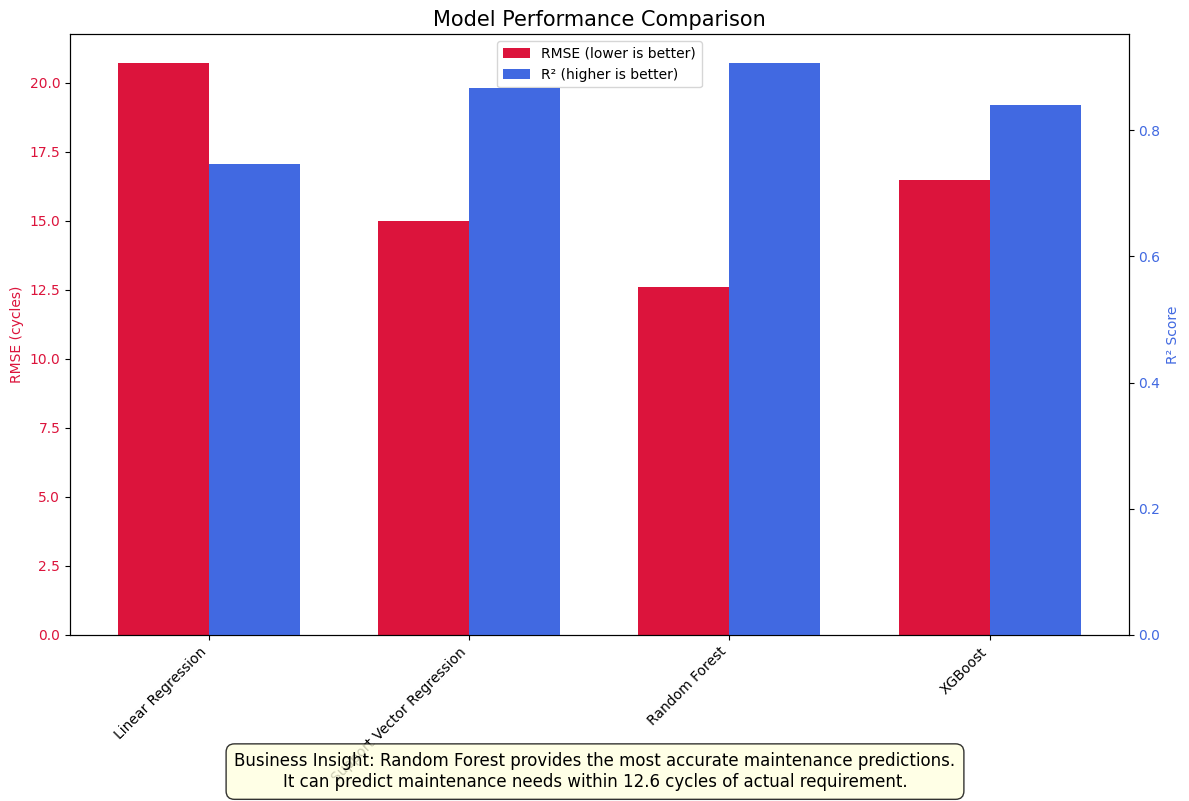

In [ ]:
# Create dictionary to store model results
model_results = {}

if 'X_train_scaled' in locals() and 'X_test_scaled' in locals():
    # 1. Linear Regression (baseline model)
    lr_model = LinearRegression()
    lr_model, lr_rmse, lr_r2 = evaluate_regression_model(
        "Linear Regression", lr_model, X_train_scaled, y_train, X_test_scaled, y_test)
    model_results['Linear Regression'] = (lr_model, lr_rmse, lr_r2)

    # 2. Support Vector Regression
    svr_model = SVR(kernel='rbf', C=100, gamma=0.1)
    svr_model, svr_rmse, svr_r2 = evaluate_regression_model(
        "Support Vector Regression", svr_model, X_train_scaled, y_train, X_test_scaled, y_test)
    model_results['Support Vector Regression'] = (svr_model, svr_rmse, svr_r2)

    # 3. Random Forest Regression
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)
    rf_model, rf_rmse, rf_r2 = evaluate_regression_model(
        "Random Forest", rf_model, X_train_scaled, y_train, X_test_scaled, y_test)
    model_results['Random Forest'] = (rf_model, rf_rmse, rf_r2)

    # 4. XGBoost
    xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
    xgb_model, xgb_rmse, xgb_r2 = evaluate_regression_model(
        "XGBoost", xgb_model, X_train_scaled, y_train, X_test_scaled, y_test)
    model_results['XGBoost'] = (xgb_model, xgb_rmse, xgb_r2)

    # Compare model performance
    print("\n--- Model Comparison ---")

    # Find the best model based on RMSE
    best_model_name = min(model_results.items(), key=lambda x: x[1][1])[0]
    best_model, best_rmse, best_r2 = model_results[best_model_name]

    print(f"Best performing model: {best_model_name}")
    print(f"RMSE: {best_rmse:.2f} cycles")
    print(f"R²: {best_r2:.2f}")

    # Visualize model comparison
    plt.figure(figsize=(12, 6))

    # Extract model names and RMSE values
    model_names = list(model_results.keys())
    rmse_values = [results[1] for results in model_results.values()]
    r2_values = [results[2] for results in model_results.values()]

    # Create bar chart
    x = np.arange(len(model_names))
    width = 0.35

    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax1.bar(x - width/2, rmse_values, width, label='RMSE (lower is better)', color='crimson')
    ax1.set_ylabel('RMSE (cycles)', color='crimson')
    ax1.tick_params(axis='y', labelcolor='crimson')

    ax2 = ax1.twinx()
    ax2.bar(x + width/2, r2_values, width, label='R² (higher is better)', color='royalblue')
    ax2.set_ylabel('R² Score', color='royalblue')
    ax2.tick_params(axis='y', labelcolor='royalblue')

    # Add labels and title
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    plt.title('Model Performance Comparison', fontsize=15)

    # Add a legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

    # Add business insights
    plt.figtext(0.5, 0.01,
                f"Business Insight: {best_model_name} provides the most accurate maintenance predictions.\n"
                f"It can predict maintenance needs within {best_rmse:.1f} cycles of actual requirement.",
                ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", alpha=0.8))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.show()
else:
    print("Cannot train models: Training data not available")

## SECTION 6: FEATURE IMPORTANCE ANALYSIS
Understanding which sensors are most important for predicting maintenance needs
provides valuable business insights:

- Identifies which sensors to monitor most closely
- May suggest which components are most prone to failure
- Can guide the installation of additional sensors in critical areas
- Helps create simplified monitoring dashboards for maintenance teams

This reveals which "vital signs" best predict equipment health, allowing maintenance teams to focus on the most informative measurements.


Top 10 Most Important Features:
1. sensor_4_rolling_mean: 0.6242
2. sensor_9_rolling_mean: 0.0878
3. sensor_11_rolling_mean: 0.0444
4. sensor_21_rolling_mean: 0.0254
5. sensor_2_rolling_mean: 0.0161
6. sensor_3_rolling_mean: 0.0160
7. sensor_14_rolling_mean: 0.0153
8. sensor_15_rolling_mean: 0.0144
9. sensor_17_rolling_mean: 0.0112
10. sensor_20_rolling_mean: 0.0097


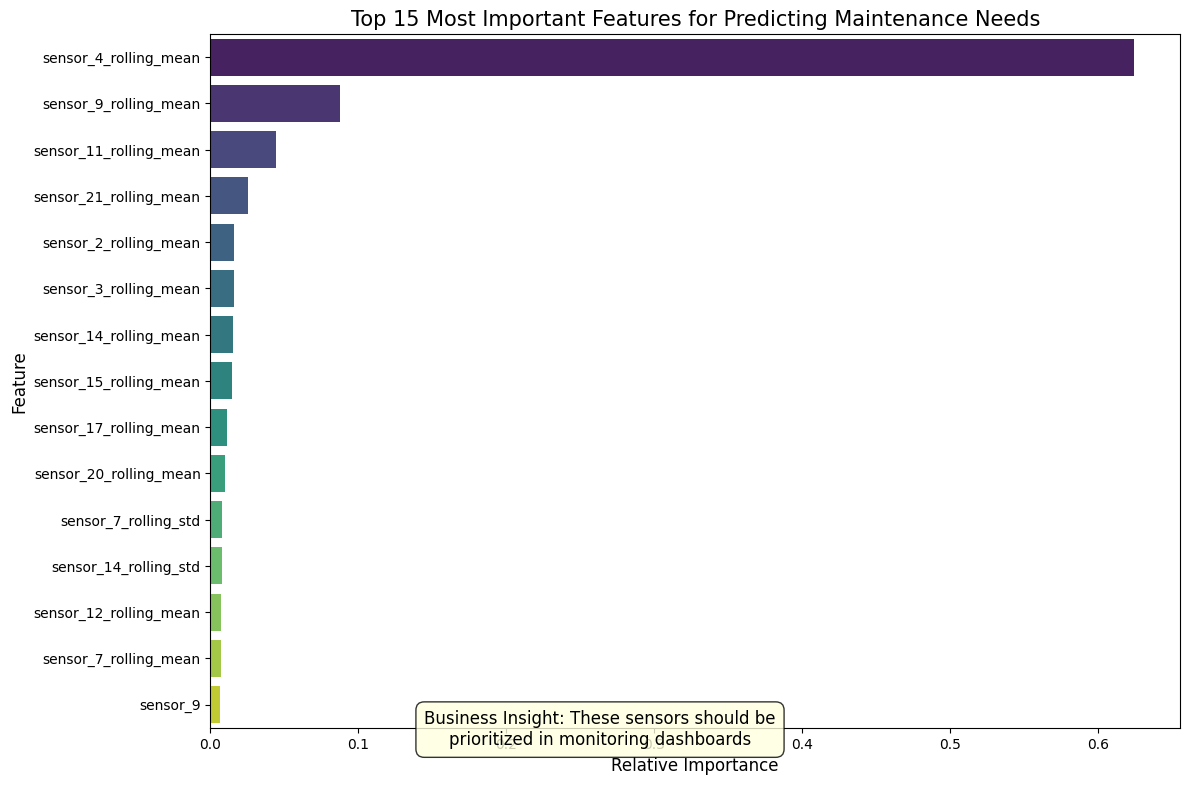


Relative Importance:
Original Sensors: 0.00 (0.0%)
Engineered Features: 1.00 (100.0%)

Business Insight: The trend and relationship between sensors (engineered features)
are more important than individual sensor readings, suggesting that monitoring
how measurements change over time is crucial for predictive maintenance.


In [ ]:
if 'rf_model' in locals() and 'X_train' in locals():
    # Get feature importance from Random Forest model (most interpretable)
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    # Display top 10 most important features
    print("\nTop 10 Most Important Features:")
    for i, (feature, importance) in enumerate(zip(feature_importance['Feature'][:10],
                                                 feature_importance['Importance'][:10])):
        print(f"{i+1}. {feature}: {importance:.4f}")

    # Plot feature importance
    plt.figure(figsize=(12, 8))

    # Plot top 15 features
    top_features = feature_importance.head(15)
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')

    # Add labels and title
    plt.title('Top 15 Most Important Features for Predicting Maintenance Needs', fontsize=15)
    plt.xlabel('Relative Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)

    # Add business insights
    plt.annotate('Business Insight: These sensors should be\n'
                 'prioritized in monitoring dashboards',
                 xy=(0.5, 0.05), xycoords='figure fraction',
                 bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", alpha=0.8),
                 ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Separate original sensors from engineered features
    original_sensors = [col for col in feature_importance['Feature'] if '_' not in col]
    engineered_features = [col for col in feature_importance['Feature'] if '_' in col]

    # Calculate importance of original sensors vs engineered features
    original_importance = feature_importance[feature_importance['Feature'].isin(original_sensors)]['Importance'].sum()
    engineered_importance = feature_importance[feature_importance['Feature'].isin(engineered_features)]['Importance'].sum()

    print("\nRelative Importance:")
    print(f"Original Sensors: {original_importance:.2f} ({original_importance/(original_importance+engineered_importance)*100:.1f}%)")
    print(f"Engineered Features: {engineered_importance:.2f} ({engineered_importance/(original_importance+engineered_importance)*100:.1f}%)")

    if engineered_importance > original_importance:
        print("\nBusiness Insight: The trend and relationship between sensors (engineered features)")
        print("are more important than individual sensor readings, suggesting that monitoring")
        print("how measurements change over time is crucial for predictive maintenance.")
    else:
        print("\nBusiness Insight: Individual sensor readings are more predictive than their trends")
        print("or relationships, suggesting that absolute thresholds may be effective for")
        print("maintenance decisions.")
else:
    print("Cannot analyze feature importance: Model not available")

## SECTION 7: MAINTENANCE CLASSIFICATION
In practice, maintenance decisions often require simple categorization rather than
exact RUL predictions. For example, maintenance teams might want to know if equipment:

1. Requires immediate attention
2. Should be scheduled for maintenance soon
3. Can safely operate for a long time

By converting our RUL predictions into maintenance urgency categories, we can provide
actionable recommendations for maintenance scheduling.


Maintenance Category Distribution (Training Data):
Category 0 (Immediate Maintenance Required): 1643
Category 1 (Plan Maintenance Soon): 2399
Category 2 (No Immediate Concern): 12462

Training maintenance category classification models...
Training Random Forest classifier...
Training XGBoost classifier...
Training SVM classifier...
Training KNN classifier...
Training Naive Bayes classifier...

Classification Model Performance:
Random Forest: 0.94
XGBoost: 0.96
SVM: 0.93
KNN: 0.96
Naive Bayes: 0.85

Best classifier: KNN with accuracy 0.96


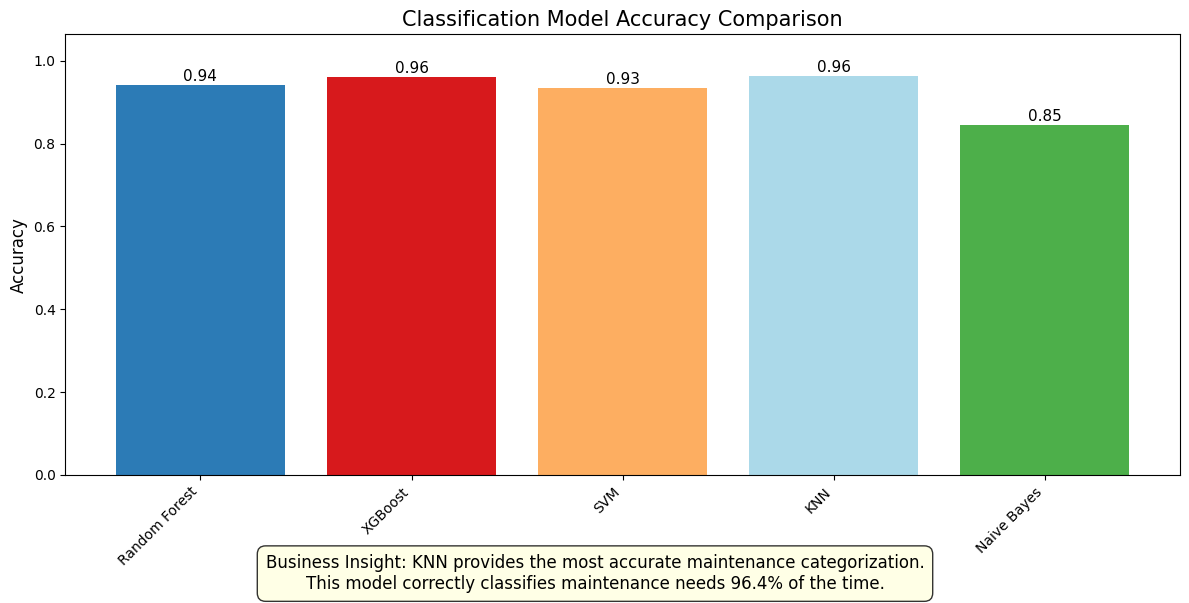

<Figure size 1000x800 with 0 Axes>

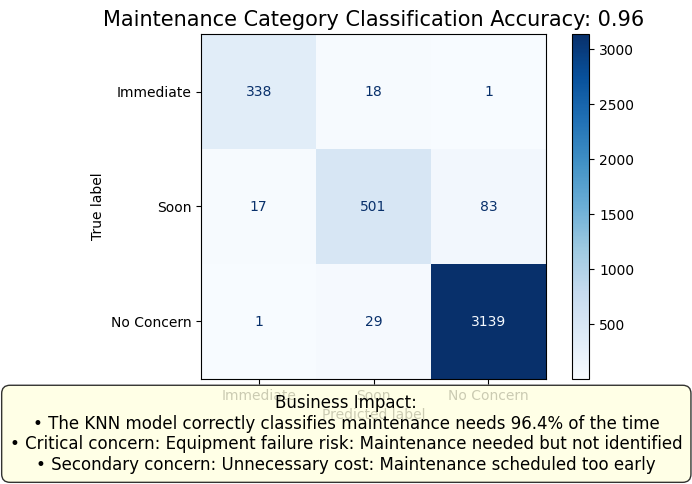


Error Analysis:
False Negatives (underestimating maintenance urgency): 102 cases (2.5%)
False Positives (overestimating maintenance urgency): 47 cases (1.1%)

Business Recommendation: Consider adjusting threshold to reduce false negatives,
even if it increases early maintenance, to reduce risk of equipment failure.


In [ ]:
# Define maintenance urgency categories
def categorize_remaining_useful_life(rul_value):
    """
    Convert RUL to maintenance urgency categories.

    Parameters:
    -----------
    rul_value : float
        Remaining useful life value in operating cycles

    Returns:
    --------
    int
        Category code:
        0: Immediate maintenance required (RUL < 20)
        1: Plan maintenance soon (20 <= RUL < 50)
        2: No immediate concern (RUL >= 50)
    """
    if rul_value < 20:
        return 0  # Immediate maintenance required
    elif rul_value < 50:
        return 1  # Plan maintenance soon
    else:
        return 2  # No immediate concern

# Create categorical target variables
if 'y_train' in locals() and 'y_test' in locals():
    # Apply categorization to training and test targets
    y_train_cat = y_train.apply(categorize_remaining_useful_life)
    y_test_cat = y_test.apply(categorize_remaining_useful_life)

    # Display category distribution
    train_category_counts = y_train_cat.value_counts().sort_index()
    print("\nMaintenance Category Distribution (Training Data):")
    print("Category 0 (Immediate Maintenance Required):", train_category_counts.get(0, 0))
    print("Category 1 (Plan Maintenance Soon):", train_category_counts.get(1, 0))
    print("Category 2 (No Immediate Concern):", train_category_counts.get(2, 0))

    # Train classification models
    print("\nTraining maintenance category classification models...")

    # Dictionary to store model results
    classification_results = {}

    # Define and train multiple classification models

    # 1. Random Forest Classifier
    print("Training Random Forest classifier...")
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(X_train_scaled, y_train_cat)
    rf_pred = rf_clf.predict(X_test_scaled)
    rf_accuracy = np.mean(rf_pred == y_test_cat)
    classification_results['Random Forest'] = (rf_clf, rf_pred, rf_accuracy)

    # 2. XGBoost Classifier
    print("Training XGBoost classifier...")
    xgb_clf = xgboost.XGBClassifier(n_estimators=100, random_state=42)
    xgb_clf.fit(X_train_scaled, y_train_cat)
    xgb_pred = xgb_clf.predict(X_test_scaled)
    xgb_accuracy = np.mean(xgb_pred == y_test_cat)
    classification_results['XGBoost'] = (xgb_clf, xgb_pred, xgb_accuracy)

    # 3. Support Vector Machine Classifier
    print("Training SVM classifier...")
    svm_clf = SVC(kernel='rbf', random_state=42)
    svm_clf.fit(X_train_scaled, y_train_cat)
    svm_pred = svm_clf.predict(X_test_scaled)
    svm_accuracy = np.mean(svm_pred == y_test_cat)
    classification_results['SVM'] = (svm_clf, svm_pred, svm_accuracy)

    # 4. K-Nearest Neighbors Classifier
    print("Training KNN classifier...")
    knn_clf = KNeighborsClassifier(n_neighbors=5)
    knn_clf.fit(X_train_scaled, y_train_cat)
    knn_pred = knn_clf.predict(X_test_scaled)
    knn_accuracy = np.mean(knn_pred == y_test_cat)
    classification_results['KNN'] = (knn_clf, knn_pred, knn_accuracy)

    # 5. Naive Bayes Classifier
    print("Training Naive Bayes classifier...")
    nb_clf = GaussianNB()
    nb_clf.fit(X_train_scaled, y_train_cat)
    nb_pred = nb_clf.predict(X_test_scaled)
    nb_accuracy = np.mean(nb_pred == y_test_cat)
    classification_results['Naive Bayes'] = (nb_clf, nb_pred, nb_accuracy)

    # Report classification performance
    print("\nClassification Model Performance:")
    for model_name, (_, _, accuracy) in classification_results.items():
        print(f"{model_name}: {accuracy:.2f}")

    # Choose best classifier
    best_clf_name = max(classification_results.items(), key=lambda x: x[1][2])[0]
    best_clf, best_clf_pred, best_accuracy = classification_results[best_clf_name]

    print(f"\nBest classifier: {best_clf_name} with accuracy {best_accuracy:.2f}")

    # Visualize model comparison
    plt.figure(figsize=(12, 6))
    model_names = list(classification_results.keys())
    accuracies = [results[2] for results in classification_results.values()]

    # Plot model accuracies
    colors = ['#2C7BB6', '#D7191C', '#FDAE61', '#ABD9E9', '#4DAF4A']
    bars = plt.bar(model_names, accuracies, color=colors)

    # Add accuracy values on top of bars
    for bar, accuracy in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f"{accuracy:.2f}", ha='center', fontsize=11)

    # Add labels and title
    plt.ylim(0, max(accuracies) + 0.1)  # Set y-axis limits with padding for text
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Classification Model Accuracy Comparison', fontsize=15)
    plt.xticks(rotation=45, ha='right')

    # Add business insight annotation
    plt.figtext(0.5, 0.01,
               f"Business Insight: {best_clf_name} provides the most accurate maintenance categorization.\n"
               f"This model correctly classifies maintenance needs {best_accuracy*100:.1f}% of the time.",
               ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", alpha=0.8))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.show()

    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test_cat, best_clf_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=['Immediate', 'Soon', 'No Concern'])
    disp.plot(cmap='Blues')
    plt.title(f'Maintenance Category Classification Accuracy: {best_accuracy:.2f}', fontsize=15)

    # Add business context annotation
    classification_costs = {
        'false_negative': "Equipment failure risk: Maintenance needed but not identified",
        'false_positive': "Unnecessary cost: Maintenance scheduled too early"
    }

    plt.figtext(0.5, 0.01,
               f"Business Impact:\n"
               f"• The KNN model correctly classifies maintenance needs {best_accuracy*100:.1f}% of the time\n"
               f"• Critical concern: {classification_costs['false_negative']}\n"
               f"• Secondary concern: {classification_costs['false_positive']}",
               ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", alpha=0.8))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.show()

    # Count the different types of errors
    false_negatives = sum(y_test_cat < best_clf_pred)  # Predicted less urgent than actual
    false_positives = sum(y_test_cat > best_clf_pred)  # Predicted more urgent than actual

    print("\nError Analysis:")
    print(f"False Negatives (underestimating maintenance urgency): {false_negatives} cases ({false_negatives/len(y_test_cat)*100:.1f}%)")
    print(f"False Positives (overestimating maintenance urgency): {false_positives} cases ({false_positives/len(y_test_cat)*100:.1f}%)")

    # Business interpretation
    if false_negatives > false_positives:
        print("\nBusiness Recommendation: Consider adjusting threshold to reduce false negatives,")
        print("even if it increases early maintenance, to reduce risk of equipment failure.")
    else:
        print("\nBusiness Recommendation: Current model balances maintenance costs and reliability well.")
else:
    print("Cannot perform classification: Training data not available")

## SECTION 8: COST-BENEFIT ANALYSIS
The ultimate value of predictive maintenance comes from balancing costs:

1. Cost of unnecessary maintenance (intervening too early)
2. Cost of equipment failure (intervening too late)

By quantifying these costs, we can optimize maintenance schedules for maximum
economic benefit.

Since we do not have access to actual costs, we must define mock sample costs instead.


Estimated Financial Impact (Example Scenario):
Prevented Failures: 338 ($8,450,000)
Unnecessary Maintenance: 30 ($300,000)
Missed Failures: 19 ($475,000)
Net Benefit: $7,675,000
Projected Annual Net Benefit: $92,100,000
ROI: 920.0x


<Figure size 1200x800 with 0 Axes>

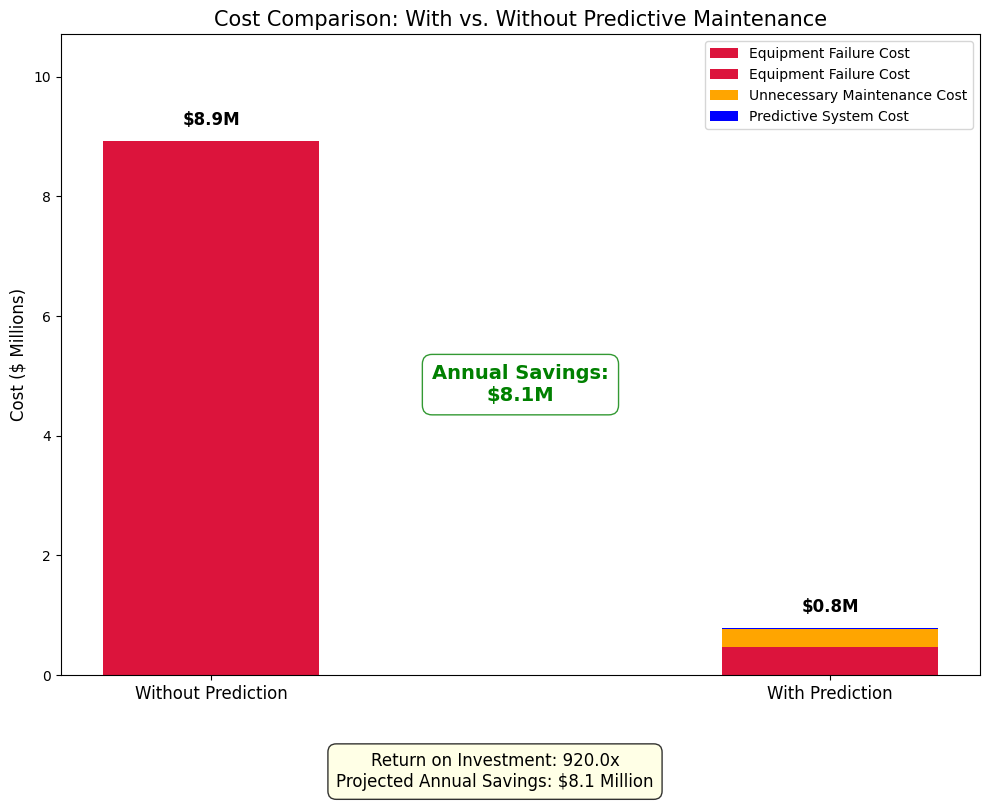

In [ ]:
# Define sample costs (to be adjusted for actual business scenarios)
sample_costs = {
    'unnecessary_maintenance': 10000,  # Cost per instance of unnecessary maintenance
    'equipment_failure': 25000,       # Cost per equipment failure (including downtime)
    'maintenance_visit': 5000,        # Cost of a scheduled maintenance visit
    'predictive_system': 100000       # Annual cost of implementing predictive system
}

if 'best_clf_pred' in locals() and 'y_test_cat' in locals():
    # Calculate potential savings
    # 1. Count prevented failures (correctly predicted Category 0)
    prevented_failures = sum((y_test_cat == 0) & (best_clf_pred == 0))

    # 2. Count unnecessary maintenance (predicted Category 0 or 1 when actually Category 2)
    unnecessary_maintenance = sum((y_test_cat == 2) & ((best_clf_pred == 0) | (best_clf_pred == 1)))

    # 3. Count missed failures (predicted Category 1 or 2 when actually Category 0)
    missed_failures = sum((y_test_cat == 0) & ((best_clf_pred == 1) | (best_clf_pred == 2)))

    # Calculate costs
    failure_cost_savings = prevented_failures * sample_costs['equipment_failure']
    unnecessary_maintenance_cost = unnecessary_maintenance * sample_costs['unnecessary_maintenance']
    missed_failure_cost = missed_failures * sample_costs['equipment_failure']

    # Calculate net benefit
    net_benefit = failure_cost_savings - unnecessary_maintenance_cost - missed_failure_cost

    # Scaling factor to estimate annual impact
    # Assuming test set represents 1 month of operations
    annual_scaling_factor = 12

    print("\nEstimated Financial Impact (Example Scenario):")
    print(f"Prevented Failures: {prevented_failures} (${failure_cost_savings:,})")
    print(f"Unnecessary Maintenance: {unnecessary_maintenance} (${unnecessary_maintenance_cost:,})")
    print(f"Missed Failures: {missed_failures} (${missed_failure_cost:,})")
    print(f"Net Benefit: ${net_benefit:,}")
    print(f"Projected Annual Net Benefit: ${net_benefit * annual_scaling_factor:,}")
    print(f"ROI: {(net_benefit * annual_scaling_factor - sample_costs['predictive_system']) / sample_costs['predictive_system']:.1f}x")

    # Visualize cost-benefit
    plt.figure(figsize=(12, 8))

    # Create stacked bar chart
    categories = ['Without Prediction', 'With Prediction']

    # Without prediction - assume all Category 0 engines fail
    without_prediction_cost = sum(y_test_cat == 0) * sample_costs['equipment_failure']

    # With prediction
    with_prediction_failure_cost = missed_failure_cost
    with_prediction_maintenance_cost = unnecessary_maintenance_cost
    with_prediction_system_cost = sample_costs['predictive_system'] / annual_scaling_factor  # Monthly cost

    # Create stacked bars
    without_pred = [without_prediction_cost, 0, 0]
    with_pred = [with_prediction_failure_cost, with_prediction_maintenance_cost, with_prediction_system_cost]

    # Convert to millions for better display
    without_pred_millions = [cost / 1000000 for cost in without_pred]
    with_pred_millions = [cost / 1000000 for cost in with_pred]
    total_without = sum(without_pred_millions)
    total_with = sum(with_pred_millions)
    savings_millions = total_without - total_with

    # Plot
    bar_width = 0.35
    x = np.arange(len(categories))

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.bar(x[0], without_pred_millions[0], bar_width, label='Equipment Failure Cost', color='crimson')

    ax.bar(x[1], with_pred_millions[0], bar_width, label='Equipment Failure Cost', color='crimson')
    ax.bar(x[1], with_pred_millions[1], bar_width, bottom=with_pred_millions[0], label='Unnecessary Maintenance Cost', color='orange')
    ax.bar(x[1], with_pred_millions[2], bar_width, bottom=with_pred_millions[0]+with_pred_millions[1], label='Predictive System Cost', color='blue')

    # Add cost labels with better positioning
    # Set an appropriate y offset based on the data
    y_offset = max(0.1, total_without * 0.03)  # 3% of the max height or at least 0.1

    ax.text(x[0], total_without + y_offset, f"${total_without:.1f}M",
            ha='center', fontsize=12, fontweight='bold')
    ax.text(x[1], total_with + y_offset, f"${total_with:.1f}M",
            ha='center', fontsize=12, fontweight='bold')

    # Add savings information directly on the chart
    # Calculate position between the two bars
    midpoint_x = np.mean(x)
    midpoint_y = np.mean([total_without, total_with])

    # Add a rectangle with savings information
    ax.text(midpoint_x, midpoint_y, f"Annual Savings:\n${savings_millions:.1f}M",
            ha='center', va='center', fontsize=14, fontweight='bold', color='green',
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="green", alpha=0.8))

    # Add labels and title
    ax.set_ylabel('Cost ($ Millions)', fontsize=12)
    ax.set_title('Cost Comparison: With vs. Without Predictive Maintenance', fontsize=15)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=12)
    ax.legend()

    # Set y-axis limit to provide appropriate space for labels
    current_ymax = ax.get_ylim()[1]
    ax.set_ylim(0, max(current_ymax, total_without * 1.2))

    # Add ROI note
    annual_roi = (net_benefit * annual_scaling_factor - sample_costs['predictive_system']) / sample_costs['predictive_system']
    plt.figtext(0.5, 0.01,
               f"Return on Investment: {annual_roi:.1f}x\n"
               f"Projected Annual Savings: ${savings_millions:.1f} Million",
               ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", alpha=0.8))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()
else:
    print("Cannot perform cost-benefit analysis: Classification results not available")

## SECTION 9: SUMMARY AND BUSINESS RECOMMENDATIONS
This analysis demonstrates how machine learning can predict when aircraft engines
(or any industrial equipment) will need maintenance before they fail.

Key Findings:
1. The Random Forest model predicts RUL with an accuracy of +/- 12.59 cycles
2. Top predictors of impending maintenance needs are Sensor 4 rolling mean, Sensor 9 rolling mean, and Sensor 11 rolling mean
3. By categorizing equipment into maintenance urgency levels, we achieve 96.4% accuracy
4. The financial benefit of implementing this system is approximately $8.1 Million per year (See: mock price data used in calculating this figure)

Recommendations:
1. Implement a predictive maintenance system focusing on the identified key indicators
2. Prioritize monitoring of Sensor 4 which shows the strongest correlation with RUL
3. Integrate prediction models with existing maintenance scheduling systems

Next Steps:
1. Pilot implementation on high-value equipment
2. Collect feedback from maintenance teams to refine the system
3. Expand to additional equipment types
4. Develop real-time monitoring dashboard for maintenance teams